# Активное обучение

## Введение

Активное обучение --- это вид обучения с учителем, при котором модель определяет следующий объект, который будет добавлен в обучающую выборку.

Активное обучение используется в том случае, когда есть необходимость сэкономить ресурсы на разметке объектов для обучающей выборки.

Общая схема активного обучения следующая:
0. Имеется начальная обучающая выборка малого размера и пул неразмеченных объектов
1. На вход модели подаётся начальная выборка
2. Модель обучается
3. Согласно некоторой стратегии определяется объект, добавление которого в обучающую выборку сильнее всего улучшит модель
4. Объект передаётся на разметку и добавляется в обучающую выборку
5. Процесс повторяется с шага 2.

Пул объектов не обязан быть фиксированным, он может также представлять из себя поток объектов (как запросы в поисковике) или, в специфических ситуациях, необходимый объект может быть даже синтезирован.

Существует множество различных стратегий выбора объектов из пула:
1. Выбор по неуверенности (uncertainty sampling)
2. Выбор по несогласию в комитете (query by committee)
3. Выбор по ожидаемому изменению модели (expected model change)
4. Выбор по ожидаемому сокращению ошибки (expected error reduction)
5. Сокращение дисперсии (variance reduction) и др.

Каждая из стратегий фиксирует одну идею, но конкретных формализаций одной идеи может быть несколько.

## Uncertainty sampling

**Данные:** стандартный датасет iris из 150 объектов, взяты только первые два признака sepal length и sepal width.

**Цель:** протестировать активное обучение в сравнении с обычным обучением с учителем в задаче классификации и сравнить различные реализации uncertainty sampling между собой.

Для реализации активного обучения была выбрана библиотека `modAL`, которая является надстройкой над `sklearn`, естественно расширяя функциональность последнего. Библиотека предоставляет широкий спектр готовых решений и позволяет также удобно интегрировать свои решения.

Кроме `modAL` на просторах интернета есть ещё несколько библиотек (например, `libact`), но они показались менее удобными.

Общий вид работы с `modAL` выглядит следующим образом:
Сначала инициализируется объект класса `ActiveLearner`, в конструктор которого передаются: классификатор `estimator` из `sklearn`, стратегия выбора `query_strategy`, и начальная выборка объектов `X_training` вместе с их лейблами `y_training`.

    learner = ActiveLearner(
        estimator = RandomForestClassifier(),
        query_strategy = query_strategy(),
        X_training = X_training, y_training = y_training
    )

Далее при помощи метода `query()` класса `ActiveLearner` выбирается объект из пула `X_pool`, который передаётся в качестве аргумента (возвращается индекс объекта и сам объект)

    query_idx, query_inst = learner.query(X_pool)

Далее получаем лейбл для объекта от ясновидящих, после чего передаём его в метод `teach()`, который дообучит модель.

    learner.teach(X_pool[query_idx], y_new)
    
Для класса `ActiveLearner` доступны методы `predict()` и `fit()`, последний из которых нужен для обучения модели с нуля (при инициализации объекта класса модель сразу обучается на начальном наборе объектов).

In [1]:
%matplotlib inline

### Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.datasets.samples_generator import make_blobs
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import *
from modAL.disagreement import *
from modAL.expected_error import expected_error_reduction

h = .02  # step size in the mesh

Ниже определяется функция, которой будут строиться все графики далее.

In [2]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Define function for classification plotting
def plt_clf_map(clf, X, y, title, index = None):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    if index is None:
        plt.figure()
    if index == 1:
        plt.figure(figsize = (13, 8))
        plt.subplots_adjust(hspace = 0.4, wspace = 0.3)
    if index is not None:
        plt.subplot(2, 2, index)
    
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the test points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)

Импортируем iris и разделим его на `train` и `test` выборки. В `test` были выбраны 50 объектов, в обучении моделей они участвовать не будут.

In [3]:
### Import data
iris = datasets.load_iris()
iris_X = iris.data[:, :2] # we only take the first two features.
iris_y = iris.target

### Divide into train and test
# A random permutation, to split the data randomly
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-50]]
iris_y_train = iris_y[indices[:-50]]
iris_X_test = iris_X[indices[-50:]]
iris_y_test = iris_y[indices[-50:]]

Для начала методом k соседей (где k=3) по всему тренировочному сету будет построена модель классификации. Для целей демонстрации параметры модели не подбирались оптимальными.

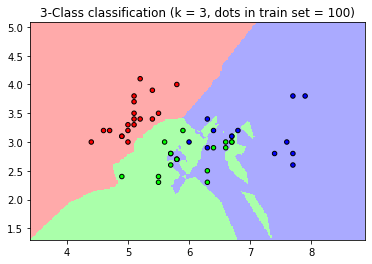

In [4]:
n_neighbors = 3
clf = KNeighborsClassifier(n_neighbors = n_neighbors)
clf.fit(iris_X_train, iris_y_train)
plt_clf_map(clf = clf, X = iris_X_test, y = iris_y_test, 
            title = "3-Class classification (k = %i, dots in train set = %i)"
            % (n_neighbors, len(iris_X_train)))

plt.show()

Посмотрим на картинку выше и запомним, как выглядит классификация по всем 100 точкам. В дальнейшем, чем ближе будут картинки остальных моделей, тем лучше прошла классификация.

Теперь посмотрим, каково минимальное количество объектов необходимо выбранному методу, чтобы получить более менее разумную классификацию.

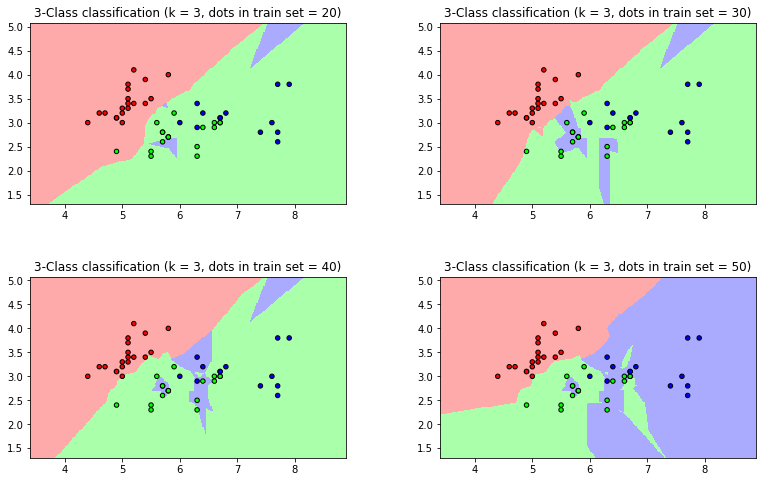

In [5]:
### Learn kNeighbors model
index = 1
for dots in [20, 30, 40, 50]:
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(iris_X_train[:dots], iris_y_train[:dots])
    plt_clf_map(clf = clf, X = iris_X_test, y = iris_y_test, 
                title = "3-Class classification (k = %i, dots in train set = %i)"
              % (n_neighbors, dots), index = index)
    index = index + 1

plt.show()

Из графиков выше видно, что модели необходимо хотя бы 50 объектов. Посмотрим, удастся ли при помощи активного обучения снизить это число.

Ниже определяется функция, внутри которой происходит активное обучение на 10 точках в начальной выборке и на 10, 20, 30 и 40 точках в пуле.

Выбрана стратегия uncertainty sampling. В переложении на терминологию из презентации эта стратегия соответствует принципу наимешьшей достоверности (least confidence).

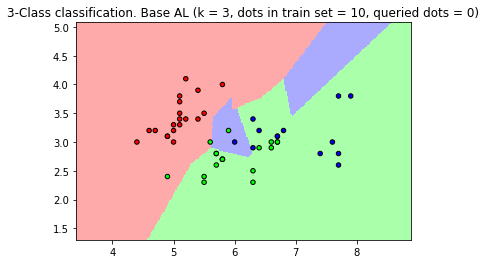

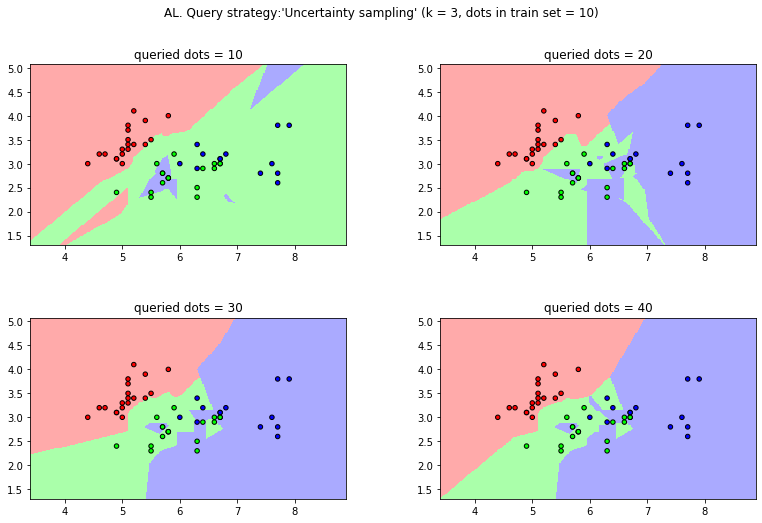

In [6]:
def AL_uncert(query_strategy, title):
    base_dots = 10
    X_al_train = iris_X_train[:base_dots]
    y_al_train = iris_y_train[:base_dots]

    # initializing the learner
    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors = n_neighbors),
        query_strategy = query_strategy,
        X_training=X_al_train, y_training=y_al_train
    )

    plt_clf_map(clf = learner, X = iris_X_test, y = iris_y_test, 
                    title = "3-Class classification. Base AL (k = %i, dots in train set = %i, queried dots = 0)"
                  % (n_neighbors, base_dots))

    plt.show()

    index = 1
    for dots in [10, 20, 30, 40]:
        X_al_pool = iris_X_train[base_dots:50]
        y_al_pool = iris_y_train[base_dots:50]
        for i in range(dots):
            # query for labels
            query_idx, query_inst = learner.query(X_al_pool)

            # supply label for queried instance
            learner.teach(X_al_pool[query_idx], y_al_pool[query_idx])
            X_al_pool = np.delete(X_al_pool, (query_idx), 0)
            y_al_pool = np.delete(y_al_pool, (query_idx), 0)

        plt_clf_map(clf = learner, X = iris_X_test, y = iris_y_test, 
                    title = "queried dots = %i"
                  % (dots), index = index)
        index = index + 1
    
    plt.suptitle("AL. Query strategy:'%s' (k = %i, dots in train set = %i)" % (title, n_neighbors, base_dots))
    plt.show()
    
AL_uncert(query_strategy = uncertainty_sampling, title = "Uncertainty sampling")

Видно, что уже на 20 дополнительных объектах (в сумме с начальными их 30) модель даёт адекватный результат. Таким образом, точек потребовалось меньше.

Ниже приведены примеры ещё двух реализаций стратегии выбора по неуверенности: margin sampling и entropy sampling.

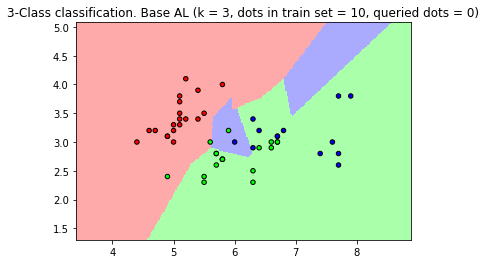

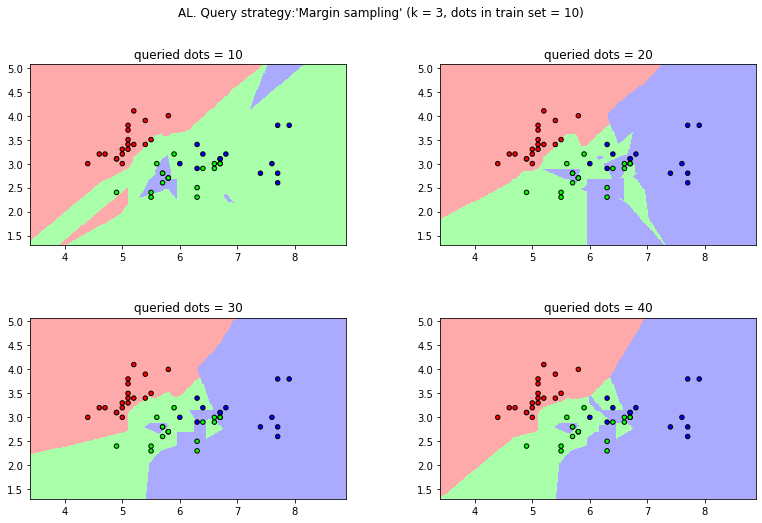

In [7]:
AL_uncert(query_strategy = margin_sampling, title = "Margin sampling")

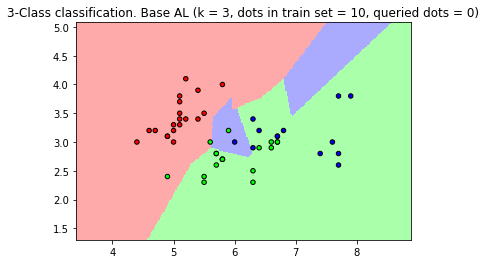

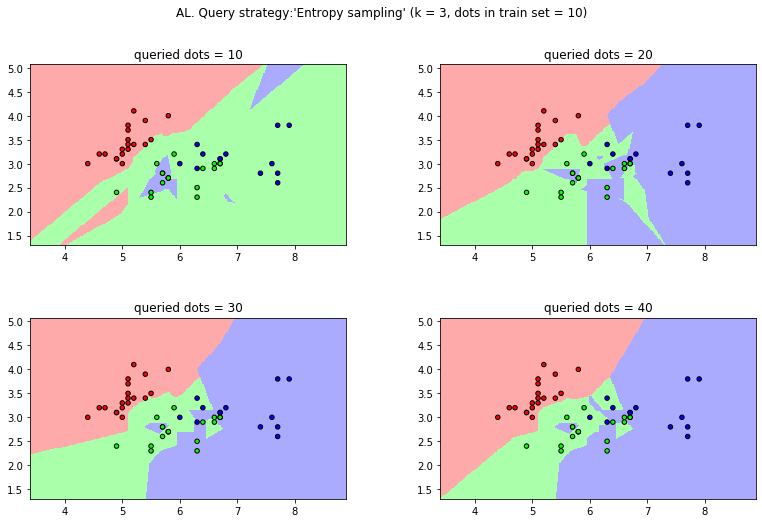

In [8]:
AL_uncert(query_strategy = entropy_sampling, title = "Entropy sampling")

В данном примере разницы между uncertainty sampling, margin sampling и entropy sampling не оказалось.

## Query by committee

**Цель:** сравнить стратегии query by committee между собой и с uncertainty sampling.

Для комитета реализация процесса немного отличается, поскольку необходимо задавать набор моделей. Для создания комитета используется класс `Committee`, в конструктор которого в качестве аргумента передаётся список объектов `ActiveLearner`.

В остальном для класса `Committee` доступны те же методы, что и для класса `ActiveLearner`, и код особо не меняется.

Приведены стратегии Max disagreement sampling и Vote entropy sampling.

Комитет составляют две модели: k ближайших соседей с k=1 и k=5.

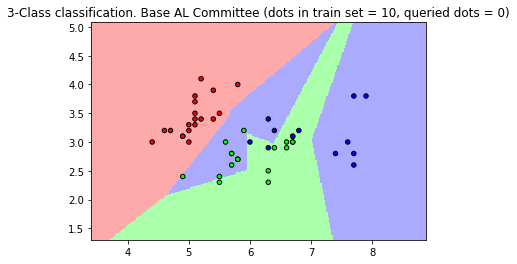

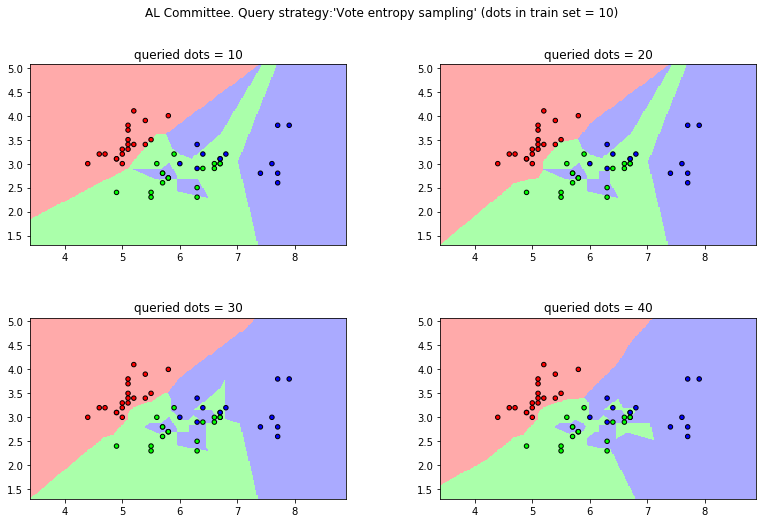

In [9]:
def AL_committee(query_strategy, title):
    base_dots = 10
    X_al_train = iris_X_train[:base_dots]
    y_al_train = iris_y_train[:base_dots]

    # initializing the learner
    learner_list = []
    for n_neighbors in [1, 5]:
        learner = ActiveLearner(
            estimator=KNeighborsClassifier(n_neighbors = n_neighbors),
            query_strategy = query_strategy,
            X_training=X_al_train, y_training=y_al_train
        )
        
        learner_list.append(learner)

#     learner = ActiveLearner(
#             estimator=KNeighborsClassifier(n_neighbors = n_neighbors),
#             query_strategy = query_strategy,
#             X_training=X_al_train, y_training=y_al_train
#         )
    
#     learner_list.append(learner)
    
#     learner = ActiveLearner(
#             estimator=RandomForestClassifier(n_estimators=100),
#             query_strategy = query_strategy,
#             X_training=X_al_train, y_training=y_al_train
#         )
    
#     learner_list.append(learner)

    committee = Committee(learner_list=learner_list)
    plt_clf_map(clf = committee, X = iris_X_test, y = iris_y_test, 
                    title = "3-Class classification. Base AL Committee (dots in train set = %i, queried dots = 0)"
                  % (base_dots))

    plt.show()

    index = 1
    for dots in [10, 20, 30, 40]:
        X_al_pool = iris_X_train[base_dots:50]
        y_al_pool = iris_y_train[base_dots:50]
        for i in range(dots):
            # query for labels
            query_idx, query_inst = committee.query(X_al_pool)

            # supply label for queried instance
            committee.teach(X_al_pool[query_idx], y_al_pool[query_idx])
            X_al_pool = np.delete(X_al_pool, (query_idx), 0)
            y_al_pool = np.delete(y_al_pool, (query_idx), 0)

        plt_clf_map(clf = committee, X = iris_X_test, y = iris_y_test, 
                    title = "queried dots = %i"
                  % (dots), index = index)
        index = index + 1
    
    plt.suptitle("AL Committee. Query strategy:'%s' (dots in train set = %i)" % (title, base_dots))
    plt.show()
    
AL_committee(query_strategy = vote_entropy_sampling, title = "Vote entropy sampling")

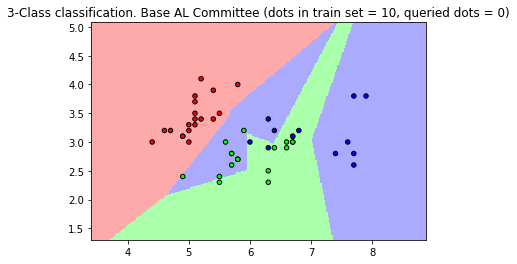

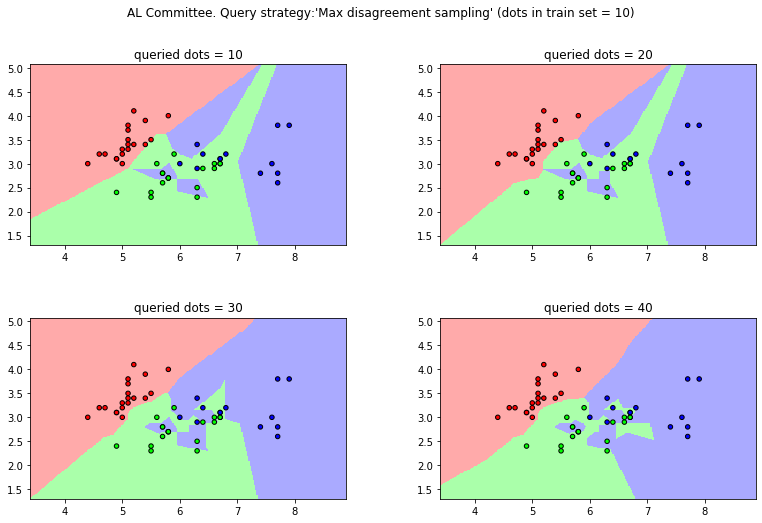

In [10]:
AL_committee(query_strategy = max_disagreement_sampling, title = "Max disagreement sampling")

Стратегия Max disagreement sampling соответствует максимизации среднего дивергенции Кульбака-Лейблера, а Vote entropy sampling --- принципу максимума энтропии.

В данном случае различия между результатами применения стратегий можно заметить. На 30 дополнительных точках Vote entropy sampling показывает себя лучше. 

Обе стратегии дают результат на 10 дополнительных точках лучше, чем uncertainty sampling.

## Expected error reduction

**Цель:** сравнить стратегию expected error reduction с предыдущими стратегиями.

Возвращаемся к модели k соседей с k=3. Единственной особенностью здесь является то, что для подсчёта score каждого объекта, требуется чтобы в пуле объектов было не меньше двух.


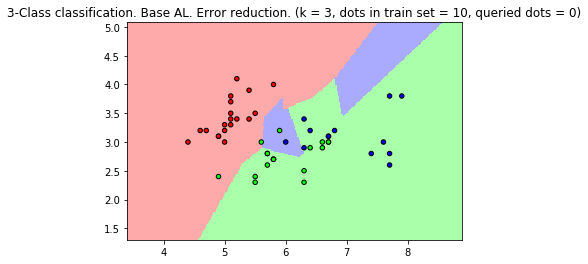

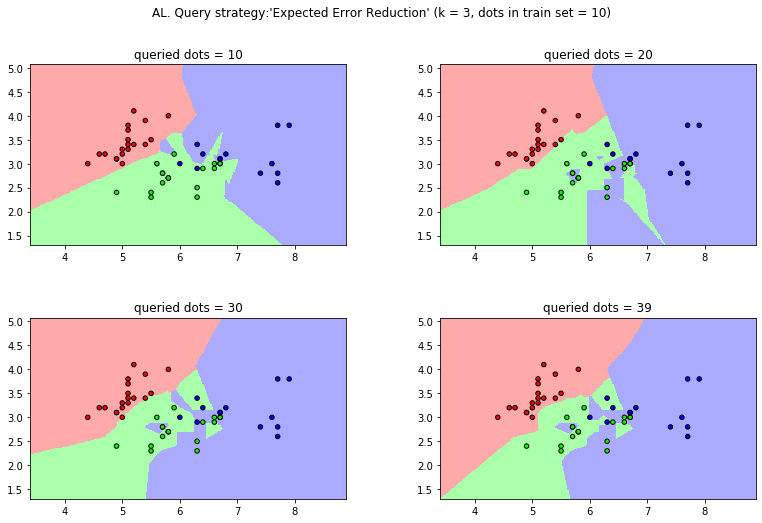

In [11]:
n_neighbors = 3
base_dots = 10
X_al_train = iris_X_train[:base_dots]
y_al_train = iris_y_train[:base_dots]

# initializing the learner
learner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors = n_neighbors),
    query_strategy = expected_error_reduction,
    X_training=X_al_train, y_training=y_al_train
)

plt_clf_map(clf = learner, X = iris_X_test, y = iris_y_test, 
                title = "3-Class classification. Base AL. Error reduction. (k = %i, dots in train set = %i, queried dots = 0)"
              % (n_neighbors, base_dots))

plt.show()

index = 1
for dots in [10, 20, 30, 39]:
    X_al_pool = iris_X_train[base_dots:50]
    y_al_pool = iris_y_train[base_dots:50]
    for i in range(dots):
        # query for labels
        query_idx, query_inst = learner.query(X_al_pool)

        # supply label for queried instance
        learner.teach(X_al_pool[query_idx], y_al_pool[query_idx])
        X_al_pool = np.delete(X_al_pool, (query_idx), 0)
        y_al_pool = np.delete(y_al_pool, (query_idx), 0)

    plt_clf_map(clf = learner, X = iris_X_test, y = iris_y_test, 
                title = "queried dots = %i"
              % (dots), index = index)
    index = index + 1

plt.suptitle("AL. Query strategy:'Expected Error Reduction' (k = %i, dots in train set = %i)" % (n_neighbors, base_dots))
plt.show()


На данном примере стратегия expected error reduction дала лучший результат, чем все остальные стратегии, на 10 дополнительных точках. Хотя обучение модели с этой стратегией было самым долгим по времени.

## Визуализация выбора точек

**Цель**: посмотреть на двух модельных задачах, какие точки будут выбраны первыми: далёкие или близкие к границе между кластерами.

Промоделируем возьмём выборку из смеси нормальных распределений и окружим наши данные точками на различном расстоянии. Посмотрим, какие из точек будут выбраны первыми, а какие - последними. При выборе точки из пула будем просто убирать её, не дообучая модель.

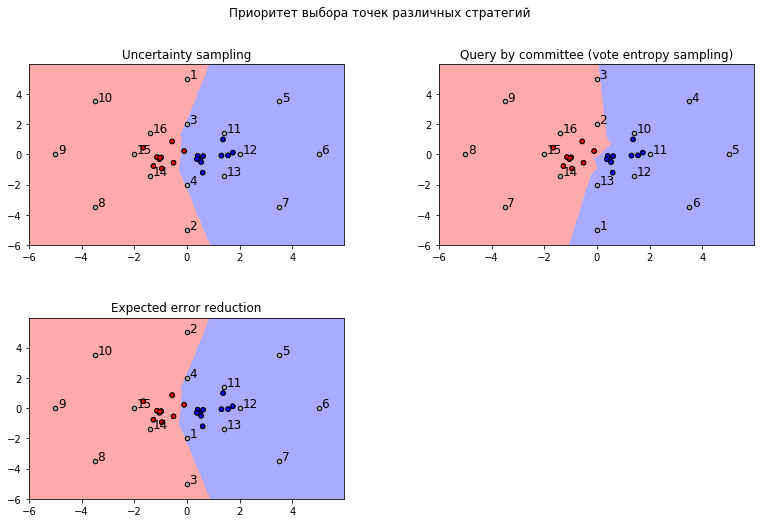

In [12]:
def plt_clf_map(clf, X, y, pX, title, index = None):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = np.concatenate((X[:, 0], pX[:, 0])).min() - 1, np.concatenate((X[:, 0], pX[:, 0])).max() + 1
    y_min, y_max = np.concatenate((X[:, 1], pX[:, 1])).min() - 1, np.concatenate((X[:, 1], pX[:, 1])).max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    if index is None:
        plt.figure()
    if index == 1:
        plt.figure(figsize = (13, 8))
        plt.subplots_adjust(hspace = 0.4, wspace = 0.3)
    if index is not None:
        plt.subplot(2, 2, index)
    
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the test points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.scatter(pX[:, 0], pX[:, 1], c="#AAAAAA",
                edgecolor='k', s=20)
    for i in range(len(pX[:, 0])):
        plt.text(pX[i, 0]+0.1, pX[i, 1]+0.05, i+1, color="black", fontsize=12)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)

train_X,train_Y = make_blobs(cluster_std=0.5,n_samples=20,centers=[[-1, 0], [1, 0]], random_state=3)

Pool_X = np.array([[0, 5], [3.5, 3.5], [5, 0], [3.5, -3.5], [0, -5], [-3.5, -3.5], [-5, 0], [-3.5, 3.5], 
               [0, 2], [1.4, 1.4], [2, 0], [1.4, -1.4], [0, -2], [-1.4, -1.4], [-2, 0], [-1.4, 1.4]])
Pool_Y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1])

# clf = KNeighborsClassifier(n_neighbors = 5)

# clf.fit(train_X, train_Y)
# plt_clf_map(clf = clf, X = train_X, y = train_Y, pX=X_pool,
#             title = "")

# initializing the learner
learner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors = 5),
    query_strategy = uncertainty_sampling,
    X_training=train_X, y_training=train_Y
)

index = 1
def func(learner, n = len(Pool_X[:, 0]), index = None, title = ""):
    pool_X = Pool_X
    pool_Y = Pool_Y
    target_X = np.zeros(shape=(n,2))
    for i in range(n):
        # query for labels
        query_idx, query_inst = learner.query(pool_X)
        target_X[i] = pool_X[query_idx]

        # supply label for queried instance
#       learner.teach(pool_X[query_idx], pool_Y[query_idx])
        pool_X = np.delete(pool_X, (query_idx), 0)
        pool_Y = np.delete(pool_Y, (query_idx), 0)

    plt_clf_map(clf = learner, X = train_X, y = train_Y, pX = target_X,
            title = title, index = index)

func(learner = learner, index = index, title = "Uncertainty sampling")
index = index + 1

learner_list = []
for n_neighbors in [1, 5]:
    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors = n_neighbors),
        query_strategy = vote_entropy_sampling,
        X_training=train_X, y_training=train_Y
    )
        
    learner_list.append(learner)


committee = Committee(learner_list=learner_list)

func(learner = committee, index = index, title = "Query by committee (vote entropy sampling)")
index = index + 1

learner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors = 5),
    query_strategy = expected_error_reduction,
    X_training=train_X, y_training=train_Y
)

func(learner = learner, index = index, n = len(Pool_X[:, 0]) - 1, title = "Expected error reduction") 
    
plt.suptitle("Приоритет выбора точек различных стратегий")
plt.show()

Точки пула окрашены серым, чтобы их можно было отличить от точек тренировочного сета. Цифры над серыми точками обозначают порядок их выбора. Как и ранее, закрашенные области показывают, как модель проводить классификацию, а цвет тренировочных точек - их настоящую принадлежность к классам.

Видно, что все алгоритмы ведут себя похожим образом в данном модельном эксперименте: в первую очередь выбираются точки поближе к границе, а среди оставшихся точек приоритет отдаётся тем, что дальше от границы. 